## 3. 랜덤 포레스트

`배깅(Bagging)` : 같은 알고리즘으로 여러 개의 분류기를 만들어서 보팅으로 최종 결정  
배깅의 대표적인 알고리즘은 **`랜덤 포레스트`**이다.  
  
`랜덤 포레스트` : 결정 트리를 기반으로 하며 여러 개의 결정 트리 분류기가 전체 데이터에서 배깅 방식으로 각자의 데이터를 샘플링해 개별적으로 학습을 수행한 뒤 최종적으로 모든 분류기가 보팅을 통해 예측 결정  
  
랜덤 포레스트는 **부트스트래핑** 분할 방식을 사용한다  
  
원래 부트스트래핑은 통계학에서 여러 개의 작은 데이터 세트를 임의로 만들어 개별 평균의 분포도를 측정하는 등의 목적을 위한 샘플링 방식을 지칭한다.  
랜덤 포레스트의 서브세트(Subset) 데이터는 이러한 부트스트래핑으로 데이터가 임의로 만들어진다. 서브세트의 데이터 건수는 전체 데이터 건수와 동일하지만, 개별 데이터가 중첩되어 만들어진다.  

In [41]:
import pandas as pd

def get_human_dataset():
    
    # 각 데이터 파일들은 공백으로 분리되어 있으므로 read_csv에서 공백 문자를 sep으로 할당.
    feature_name_df = pd.read_csv('data_set/human_activity/features.txt',sep='\s+',
                        header=None,names=['column_index','column_name'])
    # DataFrame에 피처명을 컬럼으로 부여하기 위해 리스트 객체로 다시 변환
    feature_name = feature_name_df.iloc[:, 1].values.tolist()
    
    # 학습 피처 데이터 셋과 테스트 피처 데이터을 DataFrame으로 로딩. 컬럼명은 feature_name 적용
    X_train = pd.read_csv('data_set/human_activity/train/X_train.txt',sep='\s+')
    X_train.columns = feature_name
    X_test = pd.read_csv('data_set/human_activity/test/X_test.txt',sep='\s+')
    X_test.columns = feature_name
    
    # 학습 레이블과 테스트 레이블 데이터을 DataFrame으로 로딩하고 컬럼명은 action으로 부여
    y_train = pd.read_csv('data_set/human_activity/train/y_train.txt',sep='\s+',names=['action'])
    y_test = pd.read_csv('data_set/human_activity/test/y_test.txt',sep='\s+',header=None,names=['action'])
    
    # 로드된 학습/테스트용 DataFrame을 모두 반환 
    return X_train, X_test, y_train, y_test

In [42]:
X_train, X_test, y_train, y_test = get_human_dataset()

In [43]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score
import pandas as pd
import warnings
warnings.filterwarnings('ignore')

# 결정 트리에서 사용한 get_human_dataset( )을 이용해 학습/테스트용 DataFrame 반환
X_train, X_test, y_train, y_test = get_human_dataset()

# 랜덤 포레스트 학습 및 별도의 테스트 셋으로 예측 성능 평가
rf_clf = RandomForestClassifier(random_state=0)
rf_clf.fit(X_train , y_train)
pred = rf_clf.predict(X_test)
accuracy = accuracy_score(y_test , pred)
print('랜덤 포레스트 정확도: {0:.4f}'.format(accuracy))

랜덤 포레스트 정확도: 0.9036


### 랜덤 포레스트 하이퍼 파라미터 튜닝

트리 기반의 앙상블 알고리즘의 단점은 하이퍼 파라미터가 너무 많고, 그로 인해서 튜닝을 위한 시간이 많이 필요하다는 것이다.  
  
* `n_estimator` : 랜덤 포레스트에서 결정 트리의 개수를 지정 (default = 10), 많이 설정할수록 좋은 성능을 기대할 수 있지만 계속 증가시킨다고 성능이 무조건 향상되는건 X

In [46]:
# GridSearchCV를 이용한 랜덤 포레스트의 하이퍼 파라미터 튜닝

from sklearn.model_selection import GridSearchCV

params = {
    'n_estimators':[100],
    'max_depth' : [6, 8, 10, 12], 
    'min_samples_leaf' : [8, 12, 18 ],
    'min_samples_split' : [8, 16, 20]
}

rf_clf = RandomForestClassifier(random_state = 0, n_jobs = -1) # n_jobs = -1 이용시 모든 CPU 코어 사용
grid_cv = GridSearchCV(rf_clf, param_grid = params, cv = 2, n_jobs = -1)
grid_cv.fit(X_train, y_train)

print('최적 하이퍼 파라미터:\n', grid_cv.best_params_)
print('최고 예측 정확도: {0:.4f}'.format(grid_cv.best_score_))

최적 하이퍼 파라미터:
 {'max_depth': 10, 'min_samples_leaf': 12, 'min_samples_split': 8, 'n_estimators': 100}
최고 예측 정확도: 0.8875


In [48]:
# n_estimator를 300으로 증가 시키고 별도의 테스트 데이터 세트에서 예측 성능 특정 진행
rf_clf_1 = RandomForestClassifier(n_estimators = 300, max_depth = 10, min_samples_leaf = 12,
                                 min_samples_split = 8, random_state = 0)
rf_clf_1.fit(X_train, y_train)
pred = rf_clf_1.predict(X_test)
print('예측 정확도 : {0:.4f}'.format(accuracy_score(y_test, pred)))

예측 정확도 : 0.8978


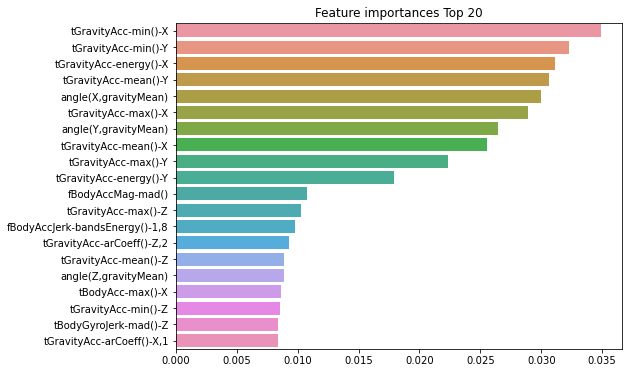

In [63]:
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

ftr_importances_values = rf_clf_1.feature_importances_
ftr_importances = pd.Series(ftr_importances_values, index = X_train.columns)
ftr_top_20 = ftr_importances.sort_values(ascending = False)[:20]

plt.figure(figsize=(8,6))
plt.title('Feature importances Top 20')
sns.barplot(x=ftr_top_20 , y = ftr_top_20.index)
plt.show()